In [84]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [149]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [150]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get Shapes from database

In [146]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [151]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))

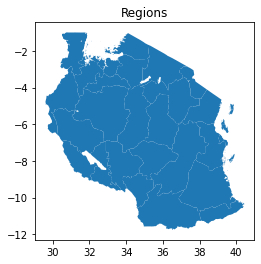

In [152]:
regions_gdf.plot()
plt.title('Regions')
plt.show()

# Load data for single shape

In [77]:
shape_gdf = regions_gdf[regions_gdf['name'] == 'Dar-es-salaam'].reset_index(drop=True)
shape_id = shape_gdf.at[0, 'id']

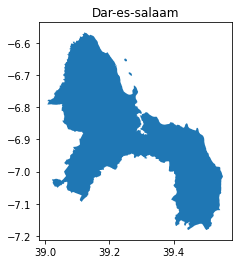

In [81]:
shape_gdf.plot()
plt.title(shape_gdf.at[0, 'name'])
plt.show()

In [112]:
q = {
    'filter_parameters': ','.join(['worldpop_popc']), # list of parameters, 
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/shape/{shape_id}?{urlencode(q)}", auth=auth).json()
shape_df = pd.DataFrame(d['data'])

In [113]:
shape_df

worldpop_popc_sum  year
0          4294334.0  2011
1          4554449.0  2012
2          4829976.0  2013
3          5121146.0  2014
4          5428955.0  2015
5          5753794.0  2016
6          6097105.5  2017
7          6459003.0  2018
8          6840113.0  2019
9          7239773.0  2020

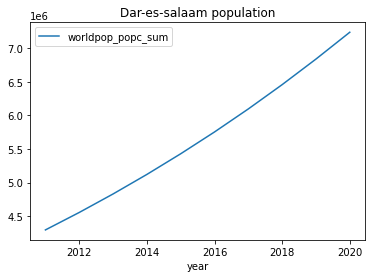

In [114]:
shape_df.plot(x='year', y=['worldpop_popc_sum'])
plt.title(f"{shape_gdf.at[0, 'name']} population")
plt.show()

# Load all data for given parameter for all shapes

In [140]:
parameter_id = 'worldpop_popc'
q = {
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
param_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

In [141]:
# print available fields
print(d['fields'])

['worldpop_popc_sum']


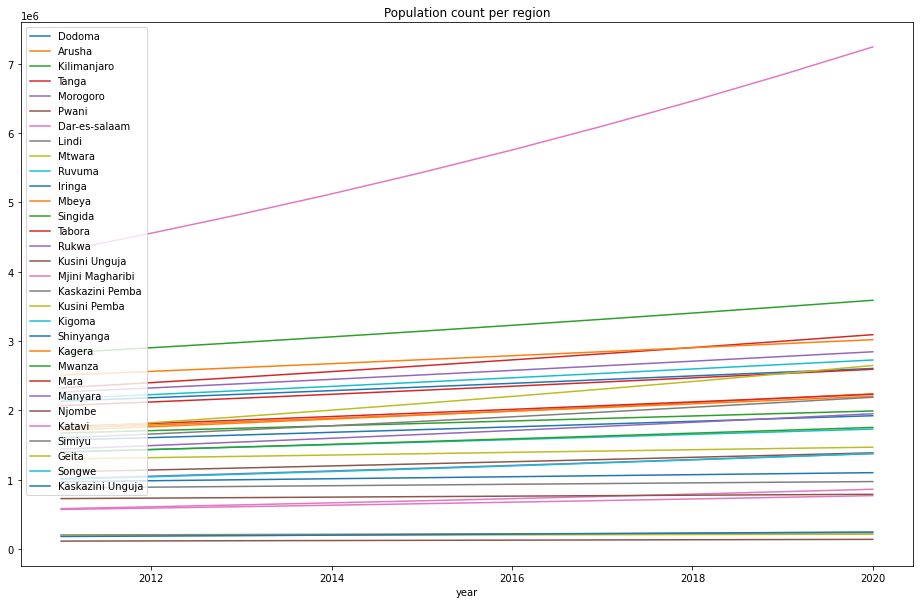

In [143]:
fig, ax = plt.subplots(figsize=(16, 10))

for sid in shape_ids:
    # only build charts for known id's from above
    if sid not in regions.keys():
        continue
    
    dfx = param_df[param_df['shape_id'] == sid]
    dfx.plot(x='year', y='worldpop_popc_sum', ax=ax, label=regions[sid])
    
plt.title('Population count per region')
plt.show()